This demo shows how to use integrated gradients to guide the adversarial attack on graph convolutional networks (GCNs) under the transductive setting (i.e., models are re-trained for attacked graph). We also show that the attacks can easily be defended via a simple pre-processing. This potentially shows the limitations of GNN models like GCN. 

This also inspires us to explore stronger adversarial attacks on graph neural networks.

In [11]:
import networkx as nx
import pandas as pd
import numpy as np
from scipy import stats
import os
import time
import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
import keras
from keras import layers, optimizers, losses, metrics, Model, regularizers
from sklearn import preprocessing, feature_extraction, model_selection
from stellargraph.core.utils import GCN_Aadj_feats_op
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_similarity_score
%matplotlib inline

### Loading the CORA network

**Downloading the CORA dataset:**
    
The dataset used in this demo can be downloaded from https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz

The following is the description of the dataset:
> The Cora dataset consists of 2708 scientific publications classified into one of seven classes.
> The citation network consists of 5429 links. Each publication in the dataset is described by a
> 0/1-valued word vector indicating the absence/presence of the corresponding word from the dictionary.
> The dictionary consists of 1433 unique words. The README file in the dataset provides more details.

Download and unzip the cora.tgz file to a location on your computer and set the `data_dir` variable to
point to the location of the dataset (the directory containing "cora.cites" and "cora.content").

In [12]:
data_dir = os.path.expanduser("~/data/cora")

Load the graph from edgelist

In [13]:
edgelist = pd.read_table(os.path.join(data_dir, "cora.cites"), header=None, names=["source", "target"])
edgelist["label"] = "cites"

/home/wuhuijun/anaconda3/envs/stellargraph/lib/python3.6/site-packages/ipykernel/__main__.py:1: FutureWarning: read_table is deprecated, use read_csv instead, passing sep='\t'.
  if __name__ == '__main__':


In [14]:
Gnx = nx.from_pandas_edgelist(edgelist, edge_attr="label")
nx.set_node_attributes(Gnx, "paper", "label")
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
node_data = pd.read_csv(os.path.join(data_dir, "cora.content"), sep='\t', header=None, names=column_names)

### Splitting the data

For machine learning we want to take a subset of the nodes for training, and use the rest for validation and testing. We'll use scikit-learn again to do this.

Here we're taking 140 node labels for training, 500 for validation, and the rest for testing.

In [15]:
train_data, test_data = model_selection.train_test_split(node_data, train_size=140, test_size=None, stratify=node_data['subject'])
val_data, test_data = model_selection.train_test_split(test_data, train_size=500, test_size=None, stratify=test_data['subject'])

In [16]:
from collections import Counter
Counter(train_data['subject'])

Counter({'Case_Based': 16,
         'Genetic_Algorithms': 22,
         'Neural_Networks': 42,
         'Probabilistic_Methods': 22,
         'Reinforcement_Learning': 11,
         'Rule_Learning': 9,
         'Theory': 18})

### Converting to numeric arrays

For our categorical target, we will use one-hot vectors that will be fed into a soft-max Keras layer during training. To do this conversion ...

We now do the same for the node attributes we want to use to predict the subject. These are the feature vectors that the Keras model will use as input. The CORA dataset contains attributes 'w_x' that correspond to words found in that publication. If a word occurs more than once in a publication the relevant attribute will be set to one, otherwise it will be zero.

In [17]:
target_encoding = feature_extraction.DictVectorizer(sparse=False)
feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]
train_targets = target_encoding.fit_transform(train_data[["subject"]].to_dict('records'))
val_targets = target_encoding.transform(val_data[["subject"]].to_dict('records'))
test_targets = target_encoding.transform(test_data[["subject"]].to_dict('records'))

node_ids = node_data.index
all_targets = target_encoding.transform(
        node_data[["subject"]].to_dict("records")
    )
node_features = node_data[feature_names]
G = sg.StellarGraph(Gnx, node_features=node_features)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5278

 Node types:
  paper: [2708]
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5278]



### Creating the GCN model in Keras

Now create a StellarGraph object from the NetworkX graph and the node features and targets. It is StellarGraph objects that we use in this library to perform machine learning tasks on.

To feed data from the graph to the Keras model we need a generator. Since GAT is a full-batch model, we use the `FullBatchNodeGenerator` class to feed node features and graph adjacency matrix to the model.

In [18]:
generator = FullBatchNodeGenerator(G, method="none", sparse=False)

For training we map only the training nodes returned from our splitter and the target values.

In [19]:
train_gen = generator.flow(train_data.index, train_targets)

Now we can specify our machine learning model, we need a few more parameters for this:

the layer_sizes is a list of hidden feature sizes of each layer in the model. In this example we use two GCN layers with 16/7-dimensional hidden node features at each layer.
activations is a list of activations applied to each layer's output
Arguments such as bias, dropout, kernel_regularizer are internal parameters of the model, execute GCN for details.

In [20]:
layer_sizes = [16, 16]
gcn = GCN(layer_sizes=layer_sizes, activations=["elu", "elu"], generator=generator, bias=True, dropout=0.3,kernel_regularizer=regularizers.l2(5e-4))

In [21]:
# Expose the input and output tensors of the GCN model for node prediction, via GCN.node_model() method:
x_inp, x_out = gcn.node_model()
# Snap the final estimator layer to x_out
x_out = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

### Training the model

Now let's create the actual Keras model with the input tensors `x_inp` and output tensors being the predictions `x_out` from the final dense layer

In [22]:
model = keras.Model(inputs=x_inp, outputs=x_out)

In [23]:
model.compile(
    optimizer=optimizers.Adam(lr=0.005),# decay=0.001),
    loss=losses.categorical_crossentropy,
    weighted_metrics=[metrics.categorical_accuracy],
)
initial_weights = model.get_weights()


Train the model, keeping track of its loss and accuracy on the training set, and its generalisation performance on the validation set (we need to create another generator over the validation data for this)

In [24]:
val_gen = generator.flow(val_data.index, val_targets)


In [25]:
N = len(node_ids)
graph_nodes = list(Gnx.nodes())
all_gen = generator.flow(graph_nodes)
[X, _, A], y_all = all_gen[0]
sample_weights = np.zeros(X.shape[1])
sample_weights[train_gen.target_indices[0]] = 1
print(sample_weights.shape)

(2708,)


Train the model

In [26]:
history = model.fit_generator(train_gen,
                    shuffle=False,
                    epochs=20,
                    verbose=2,
                    validation_data=val_gen)

Epoch 1/20
 - 4s - loss: 1.9853 - weighted_categorical_accuracy: 0.1000 - val_loss: 1.9170 - val_weighted_categorical_accuracy: 0.3060
Epoch 2/20
 - 2s - loss: 1.8873 - weighted_categorical_accuracy: 0.3500 - val_loss: 1.8711 - val_weighted_categorical_accuracy: 0.3300
Epoch 3/20
 - 2s - loss: 1.8132 - weighted_categorical_accuracy: 0.4143 - val_loss: 1.8213 - val_weighted_categorical_accuracy: 0.3300
Epoch 4/20
 - 3s - loss: 1.7328 - weighted_categorical_accuracy: 0.4714 - val_loss: 1.7734 - val_weighted_categorical_accuracy: 0.3440
Epoch 5/20
 - 3s - loss: 1.6508 - weighted_categorical_accuracy: 0.4714 - val_loss: 1.7260 - val_weighted_categorical_accuracy: 0.3600
Epoch 6/20
 - 2s - loss: 1.5832 - weighted_categorical_accuracy: 0.5214 - val_loss: 1.6785 - val_weighted_categorical_accuracy: 0.3780
Epoch 7/20
 - 3s - loss: 1.5093 - weighted_categorical_accuracy: 0.5929 - val_loss: 1.6319 - val_weighted_categorical_accuracy: 0.4180
Epoch 8/20
 - 4s - loss: 1.4217 - weighted_categorical_

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

def remove_prefix(text, prefix):
    return text[text.startswith(prefix) and len(prefix):]

def plot_history(history):
    metrics = sorted(set([remove_prefix(m, "val_") for m in list(history.history.keys())]))
    for m in metrics:
        # summarize history for metric m
        plt.plot(history.history[m])
        plt.plot(history.history['val_' + m])
        plt.title(m)
        plt.ylabel(m)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='best')
        plt.show()

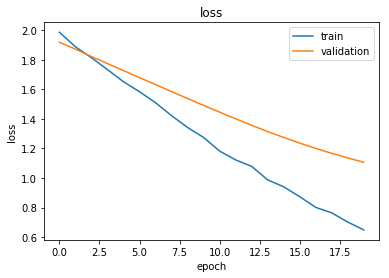

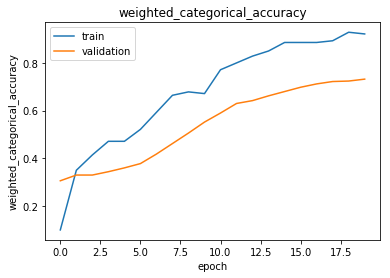

In [28]:
plot_history(history)

Evaluate the trained model on the test set

In [29]:
test_gen = generator.flow(test_data.index, test_targets)
test_metrics = model.evaluate_generator(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


Test Set Metrics:
	loss: 1.0625
	weighted_categorical_accuracy: 0.7408


# Node and link importance via saliency maps

Now we define the importances of node features, nodes, and links in the target node's neighbourhood (ego-net), and evaluate them using our library. 

Node *feature importance*: given a target node $t$ and the model's prediction of $t$'s class, for each node $v$ in its ego-net, feature importance of feature $f$ for node $v$ is defined as the change in the target node's predicted score $s(c)$ for the winning class $c$ if feature $f$ of node $v$ is perturbed. 

The overall *node importance* for node $v$ is defined here as the sum of all feature importances for node $v$, i.e., it is the amount by which the target node's predicted score $s(c)$ would change if we set all features of node $v$ to zeros.

*Link importance* for link $e=(u, v)$ is defined as the change in target node $t$'s predicted score $s(c)$ if the link $e$ is removed from the graph. Links with high importance (positive or negative) affect the target node prediction more than links with low importance. 

Node and link importances can be used to assess the role of neighbour nodes and links in model's predictions for the node(s) of interest (the target nodes). For datasets like CORA-ML, the features and edges are binary, vanilla gradients may not perform well so we use integrated gradients to compute them (https://arxiv.org/pdf/1703.01365.pdf).

Another interesting application of node and link importances is to identify model vulnerabilities to attacks via perturbing node features and graph structure (see https://arxiv.org/abs/1903.01610).

In [30]:
from stellargraph.utils.saliency_maps.integrated_gradients import IntegratedGradients
from stellargraph.utils.saliency_maps.saliency import GradientSaliency

Select the target node whose prediction is to be interpreted

Node id of the target node:

In [31]:
target_idx = 60 #index of the target node in G.nodes()
target_nid = list(G.nodes())[target_idx]

G_ego = nx.ego_graph(G, target_nid, radius=1)
print(len(G_ego.nodes()))

18


In [32]:
y_true = all_targets[list(node_ids).index(target_nid)]  # true class of the target node
print(target_nid)

1688


In [33]:

y_pred = model.predict_generator(all_gen)[0, target_idx]
class_of_interest = np.argmax(y_pred)

node_mask_train = train_gen.target_indices
node_mask_val = val_gen.target_indices

print("target node id: {}, \ntrue label: {}, \npredicted label scores: {}".format(target_nid, y_true, y_pred.round(2)))

target node id: 1688, 
true label: [0. 1. 0. 0. 0. 0. 0.], 
predicted label scores: [0.02 0.74 0.05 0.12 0.03 0.03 0.02]


Get the node feature importance by using integrated gradients

In [34]:
int_grad_saliency = IntegratedGradients(model)

For the parameters of `get_node_importance` method, `X` and `A` are the feature and adjacency matrices, respectively. `target_idx` is the node of interest, and `class_of_interest` is set as the predicted label of the node. `steps` indicates the number of steps used to approximate the integration in integrated gradients calculation. A larger value of `steps` gives better approximation, at the cost of higher computational overhead.

In [35]:
integrated_node_importance = int_grad_saliency.get_node_importance(X, A, target_idx, class_of_interest, steps=20)

In [36]:
print('\nintegrated_node_importance', integrated_node_importance.round(2))
print('integrated self-importance of target node {}: {}'.format(target_nid, integrated_node_importance[target_idx].round(2)))


integrated_node_importance [ 0.54  0.   -0.   ...  0.    0.    0.  ]
integrated self-importance of target node 1688: 1.87


Check that number of non-zero node importance values is less or equal the number of nodes in target node's K-hop ego net (where K is the number of GCN layers in the model)

In [37]:
G_ego = nx.ego_graph(G, target_nid, radius=len(gcn.activations))

In [38]:
print('Number of nodes in the ego graph: {}'.format(len(G_ego.nodes())))
print("Number of non-zero elements in integrated_node_importance: {}".format(np.count_nonzero(integrated_node_importance)))

Number of nodes in the ego graph: 188
Number of non-zero elements in integrated_node_importance: 188


Compute the link importance via integrated gradients (https://arxiv.org/pdf/1703.01365.pdf). Integrated gradients are obtained by cumulating the gradients along the path between the baseline (all-zero graph) and the state of the graph. They provide better sensitivity for the graphs with binary features and edges compared with the vanilla gradients. 

In [39]:
integrate_link_importance = int_grad_saliency.get_integrated_link_masks(X, A, target_idx, class_of_interest, A_baseline = None, steps=20)
print('integrate_link_importance.shape = {}'.format(integrate_link_importance.shape))

integrate_link_importance.shape = (2708, 2708)


Some sanity checks:
We expect the number of non-zero elements in the integrated link importance be same or less than the number of real edges in the ego graph.

In [40]:
#The built-in number_of_edges function for the ego graph does not count the self-loops and some reversed edges
#in the non-directed graph so we do the sanity check as the following.
G_ego_edges = set()
for i in np.nonzero(A[0, target_idx])[0]:
    G_ego_edges.add((graph_nodes[target_idx], graph_nodes[i]))
    for j in np.nonzero(A[0, i])[0]:
        G_ego_edges.add((graph_nodes[i], graph_nodes[j]))
print("Number of edges in the ego graph: {}".format(len(G_ego_edges)))
print("Number of non-zero elements in integrate_link_importance: {}".format(np.count_nonzero(integrate_link_importance)))

Number of edges in the ego graph: 245
Number of non-zero elements in integrate_link_importance: 245


In [41]:
sorted_indices = np.argsort(integrate_link_importance.flatten())
N = len(graph_nodes)
integrated_link_importance_rank = [
    (graph_nodes[k//N], graph_nodes[k%N])
    for k in sorted_indices[::-1]
]
topk = 10
print('Top {} most important links by integrated gradients are:\n {}'.format(topk, integrated_link_importance_rank[-topk:]))


Top 10 most important links by integrated gradients are:
 [(37879, 440815), (37879, 79809), (35, 1127913), (35, 46431), (35, 198443), (35, 249421), (35, 427606), (35, 103482), (35, 1125386), (35, 175291)]


In [42]:
#Set the labels as an attribute for the nodes in the graph. The labels are used to color the nodes in different classes.
nx.set_node_attributes(G_ego, values={x[0]:{'subject': x[1]} for x in node_data['subject'].items()})

In the following, we plot the link and node importance (computed by integrated gradients) of the nodes within the ego graph of the target node. 

For nodes, the shape of the node indicates the positive/negative importance the node has. 'round' nodes have positive importance while 'diamond' nodes have negative importance. The size of the node indicates the value of the importance, e.g., a large diamond node has higher negative importance. 

For links, the color of the link indicates the positive/negative importance the link has. 'red' links have positive importance while 'blue' links have negative importance. The width of the link indicates the value of the importance, e.g., a thicker blue link has higher negative importance.

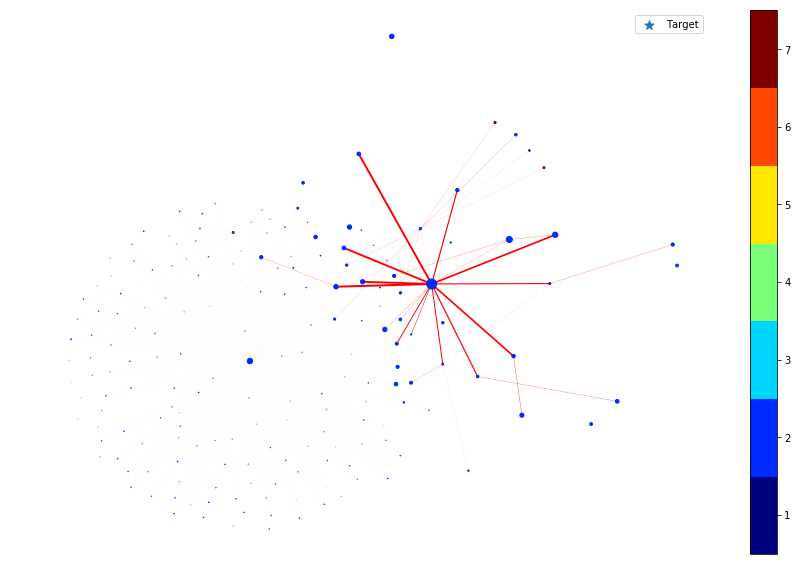

In [43]:
node_size_factor = 1e2
link_width_factor = 2

nodes = list(G_ego.nodes())
colors = pd.DataFrame([v[1]['subject'] for v in G_ego.nodes(data=True)], index=nodes, columns=['subject'])
colors = np.argmax(target_encoding.transform(colors.to_dict('records')), axis=1) + 1

fig, ax = plt.subplots(1, 1, figsize=(15, 10));
pos = nx.spring_layout(G_ego)
# Draw ego as large and red
node_sizes = [integrated_node_importance[list(G.nodes()).index(k)] for k in G_ego.nodes()]
node_shapes = ['o' if integrated_node_importance[list(G.nodes()).index(k)] > 0 else 'd' for k in G_ego.nodes()]
positive_colors, negative_colors = [], []
positive_node_sizes, negative_node_sizes = [], []
positive_nodes, negative_nodes = [], []
#node_size_sclae is used for better visualization of nodes
node_size_scale = node_size_factor/np.max(node_sizes)
for k in range(len(node_shapes)):
    if list(nodes)[k] == target_idx:
        continue
    if node_shapes[k] == 'o':
        positive_colors.append(colors[k])
        positive_nodes.append(list(nodes)[k])
        positive_node_sizes.append(node_size_scale*node_sizes[k])

    else:
        negative_colors.append(colors[k])
        negative_nodes.append(list(nodes)[k])
        negative_node_sizes.append(node_size_scale*abs(node_sizes[k]))



cmap = plt.get_cmap('jet', np.max(colors)-np.min(colors)+1)
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=positive_nodes, node_color=positive_colors, cmap=cmap, node_size=positive_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='o')
nc = nx.draw_networkx_nodes(G_ego, pos, nodelist=negative_nodes, node_color=negative_colors, cmap=cmap, node_size=negative_node_sizes, with_labels=False,
                           vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, node_shape='d')
# Draw the target node as a large star colored by its true subject
nx.draw_networkx_nodes(G_ego, pos, nodelist=[target_nid], node_size=50*abs(node_sizes[nodes.index(target_nid)]), node_shape='*',
                       node_color=[colors[nodes.index(target_nid)]], cmap=cmap, vmin=np.min(colors)-0.5, vmax=np.max(colors)+0.5, label="Target")

edges = G_ego.edges()
#link_width_scale is used for better visualization of links
weights = [integrate_link_importance[list(G.nodes()).index(u),list(G.node()).index(v)] for u,v in edges]
link_width_scale = link_width_factor/np.max(weights)
edge_colors = ['red' if integrate_link_importance[list(G.nodes()).index(u),list(G.node()).index(v)] > 0 else 'blue' for u,v in edges]

ec = nx.draw_networkx_edges(G_ego, pos, edge_color=edge_colors,  width = [link_width_scale*w for w in weights])
plt.legend()
plt.colorbar(nc, ticks=np.arange(np.min(colors),np.max(colors)+1))
plt.axis('off')
plt.show()

get the importance of the potential edges in the ego graph.

In [44]:
integrate_link_importance_potential = int_grad_saliency.get_integrated_link_masks(X, A, target_idx, class_of_interest, A_baseline = None, steps=10, non_exist_edge=True)

perturb the graph to add edges

In [45]:
sorted_indices = np.argsort(integrate_link_importance_potential.flatten().reshape(-1))
sorted_indices = np.array(sorted_indices)
nodes = list(G.nodes())
edges = list(G.edges())
print(sorted_indices)
#integrated_link_importance_rank = [(k//N, k%N) for k in sorted_indices[::-1]]
integrated_link_importance_rank_cord = [(nodes[k//N], nodes[k%N]) for k in sorted_indices[::-1]]
node_indices = list(G.nodes())
topk = 8
print('Top {} most important links to add by integrated gradients are {}'.format(topk, integrated_link_importance_rank[-topk:]))
for x,y in integrated_link_importance_rank_cord[::-1]:
    if (x, y) in edges:
        continue
    print(integrate_link_importance_potential[node_indices.index(x), node_indices.index(y)])
    topk -= 1
    G.add_edge(x, y, label='cites')
    print('add edge ({}->{})'.format(x, y))
    #we need to reshape the feature vector to make it be treated as binary by the jaccard similarity score function.
    print('jaccard similarity score between node {} and {} = {}'.format(x, y, jaccard_similarity_score(X[0,node_indices.index(x)].reshape((1, 1433)), X[0,node_indices.index(y)].reshape((1, 1433)))))
    if topk == 0:
        break
topk = 8
print('Top {} most important links to remove by integrated gradients are {}'.format(topk, integrated_link_importance_rank[-topk:]))
for x,y in integrated_link_importance_rank:
    print(integrate_link_importance[node_indices.index(x), node_indices.index(y)])
    topk -= 1
    G.remove_edge(x, y)
    print('remove edge ({}->{})'.format(x, y))
    #we need to reshape the feature vector to make it be treated as binary by the jaccard similarity score function.
    print('jaccard similarity score between node {} and {} = {}'.format(x, y, jaccard_similarity_score(X[0,node_indices.index(x)].reshape((1, 1433)), X[0,node_indices.index(y)].reshape((1, 1433)))))
    if topk == 0:
        break

[ 162857 1256812 1251396 ...  164439  162592  162532]
Top 8 most important links to add by integrated gradients are [(35, 1127913), (35, 46431), (35, 198443), (35, 249421), (35, 427606), (35, 103482), (35, 1125386), (35, 175291)]
-3.6567599408954267e-06
add edge (1688->1365)
jaccard similarity score between node 1688 and 1365 = 0.0
-1.3628910977558917e-06
add edge (1694->5462)
jaccard similarity score between node 1694 and 5462 = 0.025
-1.3628603468873734e-06
add edge (1134022->5462)
jaccard similarity score between node 1134022 and 5462 = 0.0
-1.3627759976486686e-06
add edge (1133338->5462)
jaccard similarity score between node 1133338 and 5462 = 0.02564102564102564
-1.3627304653596184e-06
add edge (1153065->5462)
jaccard similarity score between node 1153065 and 5462 = 0.0
-1.3627036487662281e-06
add edge (1103985->5462)
jaccard similarity score between node 1103985 and 5462 = 0.0
-1.3625302415221086e-06
add edge (694759->5462)
jaccard similarity score between node 694759 and 5462 = 

As one may notice, all the edges added by the perturbation (attack) are connecting nodes with share low similarities (=0 for this target node). 

Using the previous initial weights to re-initilize the model and retrain it with the perturbed graph.

In [46]:
for i in range(5):
    generator = FullBatchNodeGenerator(G, method="none", sparse=False)
    gcn = GCN(layer_sizes=layer_sizes, activations=["elu", "elu"], generator=generator, bias=True, dropout=0.3,kernel_regularizer=regularizers.l2(5e-4))
    # Expose the input and output tensors of the GCN model for node prediction, via GCN.node_model() method:
    x_inp, x_out = gcn.node_model()
    # Snap the final estimator layer to x_out
    x_out = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
    model = keras.Model(inputs=x_inp, outputs=x_out)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),# decay=0.001),
        loss=losses.categorical_crossentropy,
        weighted_metrics=[metrics.categorical_accuracy],
    )
    graph_nodes = list(Gnx.nodes())
    all_gen = generator.flow(graph_nodes)
    train_gen = generator.flow(train_data.index, train_targets)
    history = model.fit_generator(train_gen,
                        shuffle=False,
                        epochs=20,
                        verbose=2,
                        validation_data=val_gen)

    y_pred = model.predict_generator(all_gen)[0, target_idx]
    class_of_interest = np.argmax(y_pred)


    print("target node id: {}, \ntrue label: {}, \npredicted label scores: {}".format(target_nid, y_true, y_pred.round(2)))

Epoch 1/20
 - 4s - loss: 1.9704 - weighted_categorical_accuracy: 0.1357 - val_loss: 1.8966 - val_weighted_categorical_accuracy: 0.3300
Epoch 2/20
 - 2s - loss: 1.8639 - weighted_categorical_accuracy: 0.4357 - val_loss: 1.8354 - val_weighted_categorical_accuracy: 0.3480
Epoch 3/20
 - 3s - loss: 1.7583 - weighted_categorical_accuracy: 0.5000 - val_loss: 1.7805 - val_weighted_categorical_accuracy: 0.3720
Epoch 4/20
 - 2s - loss: 1.6682 - weighted_categorical_accuracy: 0.5071 - val_loss: 1.7302 - val_weighted_categorical_accuracy: 0.3800
Epoch 5/20
 - 2s - loss: 1.6049 - weighted_categorical_accuracy: 0.5071 - val_loss: 1.6850 - val_weighted_categorical_accuracy: 0.3860
Epoch 6/20
 - 2s - loss: 1.5221 - weighted_categorical_accuracy: 0.5429 - val_loss: 1.6411 - val_weighted_categorical_accuracy: 0.4020
Epoch 7/20
 - 2s - loss: 1.4534 - weighted_categorical_accuracy: 0.5857 - val_loss: 1.5970 - val_weighted_categorical_accuracy: 0.4220
Epoch 8/20
 - 3s - loss: 1.3832 - weighted_categorical_

Epoch 20/20
 - 3s - loss: 0.6193 - weighted_categorical_accuracy: 0.9714 - val_loss: 1.0463 - val_weighted_categorical_accuracy: 0.7500
target node id: 1688, 
true label: [0. 1. 0. 0. 0. 0. 0.], 
predicted label scores: [0.18 0.3  0.37 0.02 0.04 0.03 0.07]
Epoch 1/20
 - 4s - loss: 1.9684 - weighted_categorical_accuracy: 0.1500 - val_loss: 1.9259 - val_weighted_categorical_accuracy: 0.3400
Epoch 2/20
 - 3s - loss: 1.8790 - weighted_categorical_accuracy: 0.4786 - val_loss: 1.8683 - val_weighted_categorical_accuracy: 0.4400
Epoch 3/20
 - 3s - loss: 1.7928 - weighted_categorical_accuracy: 0.6071 - val_loss: 1.8119 - val_weighted_categorical_accuracy: 0.4500
Epoch 4/20
 - 3s - loss: 1.7085 - weighted_categorical_accuracy: 0.6786 - val_loss: 1.7566 - val_weighted_categorical_accuracy: 0.4600
Epoch 5/20
 - 3s - loss: 1.6164 - weighted_categorical_accuracy: 0.7286 - val_loss: 1.7016 - val_weighted_categorical_accuracy: 0.4580
Epoch 6/20
 - 3s - loss: 1.5316 - weighted_categorical_accuracy: 0.7

After the attack, the winning class changes from 1 to 2 which indicates the success of the attack.
In order to defend the attack, we will exploit the statistical evidences of the added edges. To be specific, we will perform a prepreocessing on the graph and remove the edges connecting dissimilar nodes.

In [47]:
cnt = 0
edges = list(G.edges())
for x,y in edges:
    similarity = jaccard_similarity_score(X[0,node_indices.index(x)].reshape((1, 1433)), 
                                          X[0,node_indices.index(y)].reshape((1, 1433)))
    if similarity == 0:
        G.remove_edge(x,y)
        cnt += 1
for i in range(5):
    generator = FullBatchNodeGenerator(G, method="none", sparse=False)
    gcn = GCN(layer_sizes=layer_sizes, activations=["elu", "elu"], generator=generator, bias=True, dropout=0.3,kernel_regularizer=regularizers.l2(5e-4))
    # Expose the input and output tensors of the GCN model for node prediction, via GCN.node_model() method:
    x_inp, x_out = gcn.node_model()
    # Snap the final estimator layer to x_out
    x_out = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)
    model = keras.Model(inputs=x_inp, outputs=x_out)
    model.compile(
        optimizer=optimizers.Adam(lr=0.005),# decay=0.001),
        loss=losses.categorical_crossentropy,
        weighted_metrics=[metrics.categorical_accuracy],
    )
    graph_nodes = list(Gnx.nodes())
    all_gen = generator.flow(graph_nodes)
    train_gen = generator.flow(train_data.index, train_targets)
    print('{} edges removed'.format(cnt))
    history = model.fit_generator(train_gen,
                        shuffle=False,
                        epochs=20,
                        verbose=2,
                        validation_data=val_gen)
    N = len(node_ids)
    y_pred = model.predict_generator(all_gen)[0, target_idx]
    class_of_interest = np.argmax(y_pred)

    print("target node id: {}, \ntrue label: {}, \npredicted label scores: {}".format(target_nid, y_true, y_pred.round(2)))

578 edges removed
Epoch 1/20
 - 4s - loss: 1.9800 - weighted_categorical_accuracy: 0.1357 - val_loss: 1.9389 - val_weighted_categorical_accuracy: 0.3000
Epoch 2/20
 - 3s - loss: 1.9095 - weighted_categorical_accuracy: 0.3786 - val_loss: 1.8802 - val_weighted_categorical_accuracy: 0.3640
Epoch 3/20
 - 3s - loss: 1.8135 - weighted_categorical_accuracy: 0.5000 - val_loss: 1.8314 - val_weighted_categorical_accuracy: 0.3720
Epoch 4/20
 - 3s - loss: 1.7330 - weighted_categorical_accuracy: 0.5143 - val_loss: 1.7813 - val_weighted_categorical_accuracy: 0.3820
Epoch 5/20
 - 3s - loss: 1.6377 - weighted_categorical_accuracy: 0.5714 - val_loss: 1.7342 - val_weighted_categorical_accuracy: 0.4020
Epoch 6/20
 - 3s - loss: 1.5725 - weighted_categorical_accuracy: 0.5500 - val_loss: 1.6910 - val_weighted_categorical_accuracy: 0.4120
Epoch 7/20
 - 3s - loss: 1.4874 - weighted_categorical_accuracy: 0.5643 - val_loss: 1.6487 - val_weighted_categorical_accuracy: 0.4220
Epoch 8/20
 - 3s - loss: 1.3916 - wei

Epoch 20/20
 - 4s - loss: 0.6159 - weighted_categorical_accuracy: 0.9357 - val_loss: 1.0724 - val_weighted_categorical_accuracy: 0.7380
target node id: 1688, 
true label: [0. 1. 0. 0. 0. 0. 0.], 
predicted label scores: [0.16 0.44 0.07 0.06 0.11 0.09 0.07]
578 edges removed
Epoch 1/20
 - 4s - loss: 1.9857 - weighted_categorical_accuracy: 0.1571 - val_loss: 1.9047 - val_weighted_categorical_accuracy: 0.3280
Epoch 2/20
 - 3s - loss: 1.8804 - weighted_categorical_accuracy: 0.4286 - val_loss: 1.8453 - val_weighted_categorical_accuracy: 0.3780
Epoch 3/20
 - 3s - loss: 1.7871 - weighted_categorical_accuracy: 0.4143 - val_loss: 1.7897 - val_weighted_categorical_accuracy: 0.3840
Epoch 4/20
 - 3s - loss: 1.7033 - weighted_categorical_accuracy: 0.4643 - val_loss: 1.7370 - val_weighted_categorical_accuracy: 0.4080
Epoch 5/20
 - 3s - loss: 1.6208 - weighted_categorical_accuracy: 0.4786 - val_loss: 1.6864 - val_weighted_categorical_accuracy: 0.4180
Epoch 6/20
 - 3s - loss: 1.5327 - weighted_categor

Such a simple preprocessing easily defend the attack. Now the prediction is correct.

In [38]:
print(X.shape)

(1, 2708, 1433)
